In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
col_names = [
    "poisonous?",
    
    "cap-shape",
    "cap-surface",
    "cap-color",
    
    "bruises?",
    "odor",
    
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    
    "stalk-shape",
    "stalk-root",
    
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    
    "veil-type",
    "veil-color",
    
    "ring-number",
    "ring-type",
    
    "spore-print-color",
    
    "population",
    
    "habitat"
]
df = pd.read_csv("Data/agaricus-lepiota.csv", names=col_names)
# header=None is redundant in read_csv, see read_csv documentation
display(df)

,poisonous?,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


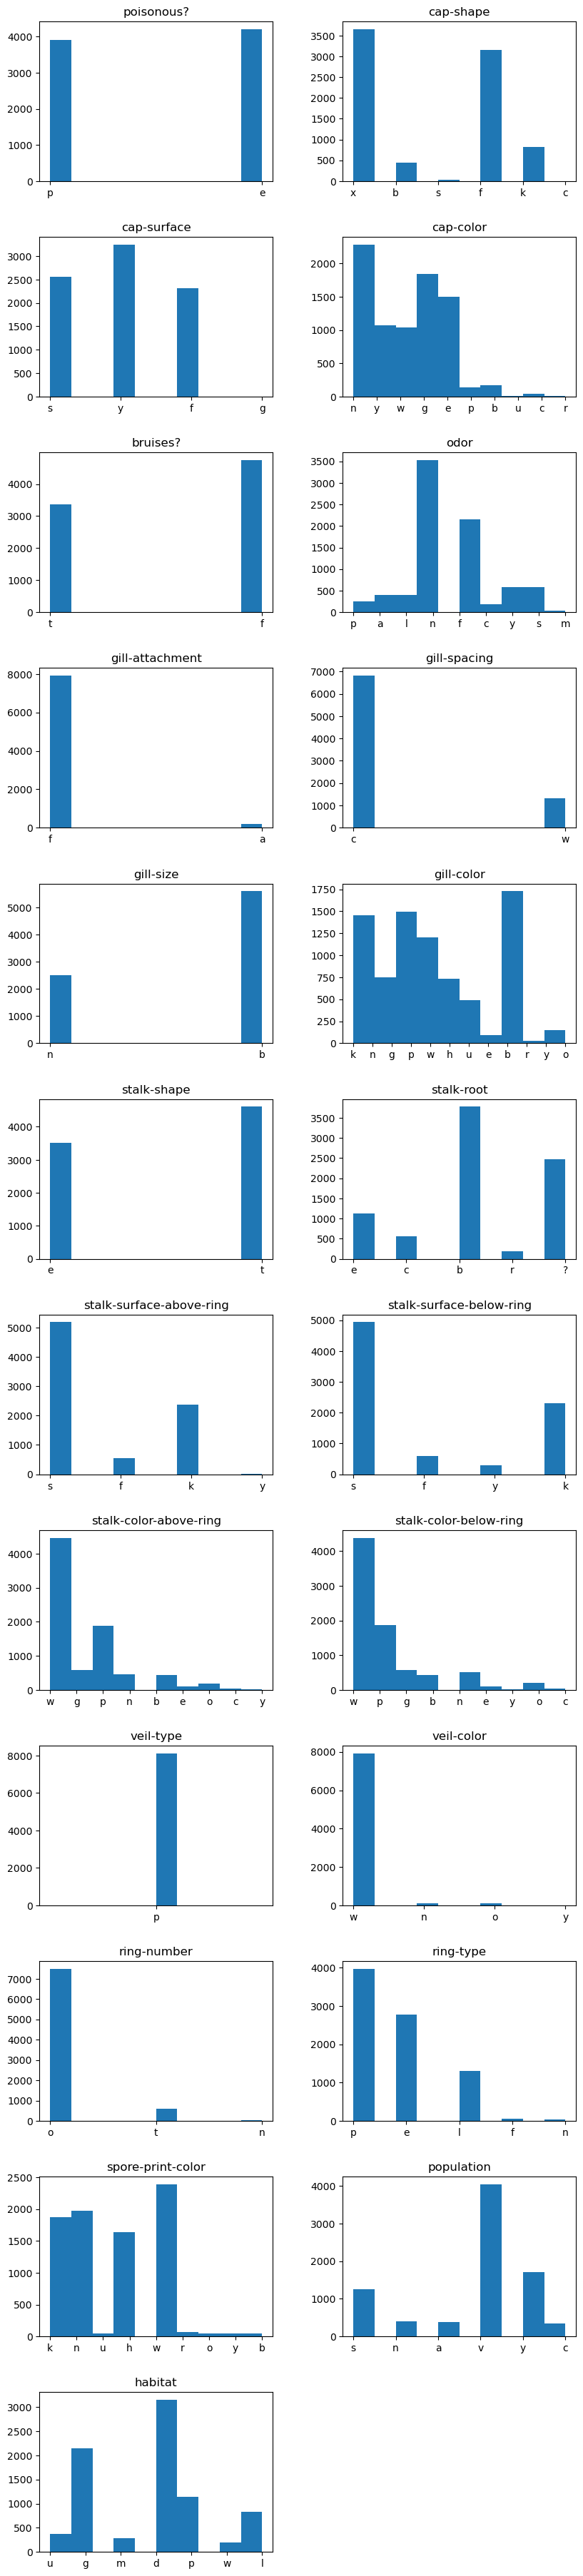

In [3]:
# We run histograms on all the features, to get an idea of value distributions
# and to discover potential patterns

for index, feature in enumerate(col_names):
    index += 1
    if(index <= len(col_names)):
        plt.subplot(12, 2, index)
        plt.hist(df.loc[:, feature])
        plt.title(feature)

plt.subplots_adjust(right=1.3,
                    top=7.5,
                    wspace=0.3,
                    hspace=0.35)

plt.show()

In [4]:
# We now make some initial obvious data discoveries

# ---first discovery---
# bruises? feature does not necessarily have much to do with
# the mushroom itself, but is likely a result of handling,
# therefore it is unlikely we'll get much real information
# from this feature and may drop it

# ---second discovery---
# stalk-root feature has a large proportion of missing values,
# which indicates we may drop the feature
df["stalk-root"].value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64

In [5]:
# ---third discovery---
# veil-type feature has just a single type of value, and because
# of this there is no information contained in this feature
df["veil-type"].value_counts()

p    8124
Name: veil-type, dtype: int64

In [6]:
# We also discovered dependencies across the features, we found
# some initial signs that gill-attachment and gill-spacing at least
# partially determine each other, and so we checked it out

ga = "gill-attachment"
gs = "gill-spacing"
ga_gs = df[[ga, gs]]

total = df.shape[0]
ga_gs_pairs = {"f-c": 0, "f-w": 0, "a-c": 0, "a-w": 0}
for i in range(total):
    row = ga_gs.iloc[i]
    r_ga = row["gill-attachment"]
    r_gs = row["gill-spacing"]
    ga_gs_pairs[r_ga + "-" + r_gs] += 1

print("Absolute Number of Pairs:\n" + str(ga_gs_pairs))

rel_ga_gs_pairs = ga_gs_pairs.copy()
for key, val in ga_gs_pairs.items():
    if (val != 0):
        rel_ga_gs_pairs[key] = val / total
    
print("Relative Number of Pairs:\n" + str(rel_ga_gs_pairs))

# we can see from results that if gill-spacing has value "w",
# then there's a 100% chance the gill-attachment value is "f",
# because there are no pairings of gill-spacing "w" with 
# gill-attachment "a", also correspondingly, if gill-attachment
# is value "a", then there's 100% chance the value in gill-spacing
# is "c", however, this discovery is not enough of a concern
# to make either feature completely redundant, so at least
# for now, we will keep both

Absolute Number of Pairs:
{'f-c': 6602, 'f-w': 1312, 'a-c': 210, 'a-w': 0}
Relative Number of Pairs:
{'f-c': 0.8126538650910882, 'f-w': 0.16149679960610536, 'a-c': 0.0258493353028065, 'a-w': 0}


In [7]:
# we've discovered 3 features which can be removed, and so we'll
# remove them now from the data we'll use for processing

df = df.drop(labels=["bruises?", "stalk-root", "veil-type"], axis=1)

In [8]:
# now we will try some ML algorithms, first with default values,
# and then we try cross-validation and grid-search to find more
# optimal paramaters, we'll also try leaving out some features

from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [9]:
# we use One-Hot-Encoding to get data we can use in training
# and prediction

dummies = pd.get_dummies(df)
display("shape of dummies: " + str(dummies.shape))
for c in dummies.columns:
    print(c)

'shape of dummies: (8124, 111)'

poisonous?_e
poisonous?_p
cap-shape_b
cap-shape_c
cap-shape_f
cap-shape_k
cap-shape_s
cap-shape_x
cap-surface_f
cap-surface_g
cap-surface_s
cap-surface_y
cap-color_b
cap-color_c
cap-color_e
cap-color_g
cap-color_n
cap-color_p
cap-color_r
cap-color_u
cap-color_w
cap-color_y
odor_a
odor_c
odor_f
odor_l
odor_m
odor_n
odor_p
odor_s
odor_y
gill-attachment_a
gill-attachment_f
gill-spacing_c
gill-spacing_w
gill-size_b
gill-size_n
gill-color_b
gill-color_e
gill-color_g
gill-color_h
gill-color_k
gill-color_n
gill-color_o
gill-color_p
gill-color_r
gill-color_u
gill-color_w
gill-color_y
stalk-shape_e
stalk-shape_t
stalk-surface-above-ring_f
stalk-surface-above-ring_k
stalk-surface-above-ring_s
stalk-surface-above-ring_y
stalk-surface-below-ring_f
stalk-surface-below-ring_k
stalk-surface-below-ring_s
stalk-surface-below-ring_y
stalk-color-above-ring_b
stalk-color-above-ring_c
stalk-color-above-ring_e
stalk-color-above-ring_g
stalk-color-above-ring_n
stalk-color-above-ring_o
stalk-color-above-ring_

In [10]:
# we extract data and labels for training and testing

X, y = dummies.loc[:, "cap-shape_b":], dummies.loc[:, "poisonous?_p"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [12]:
print("RFC training-prediction score: {:.2f}".format(rfc.score(X_train, y_train)))
print("RFC test-prediction score: {:.2f}".format(rfc.score(X_test, y_test)))

RFC training-prediction score: 1.00
RFC test-prediction score: 1.00


In [13]:
# a 100% prediction rate is suspiciously good, so we'll now
# try cross-validation to see if we might've been overly
# "lucky" with our data selection in train_test_split

res = cross_validate(rfc, X, y, cv=10, return_train_score=True)
display(res)
print("Mean Values:")
print(pd.DataFrame(res).mean())

{'fit_time': array([0.70068216, 0.73153996, 0.62834549, 0.6401937 , 0.67963505,
        0.65606928, 0.47274423, 0.48303175, 0.43599916, 0.52385211]),
 'score_time': array([0.03338075, 0.0358274 , 0.0236516 , 0.03445721, 0.03714895,
        0.03316021, 0.02406669, 0.02527165, 0.02397037, 0.02403259]),
 'test_score': array([0.68511685, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.97167488, 1.        ]),
 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

Mean Values:
fit_time       0.595209
score_time     0.029497
test_score     0.965679
train_score    1.000000
dtype: float64


In [15]:
# there seems to be some outliers, but also a consistent pattern
# of splits conforming to the 100% prediction rate, with only a
# few outliers, or in this case 2 out of 10 that are less than
# 100%, so we'll try again, but this time with stratification
# and shuffling in order to get an idea of whether these outliers
# will more or less disappear when the splits also make the original
# ordering of the data irrelevant

sample_fraction = 4
train_size, test_size = int(X.shape[0] / sample_fraction), int(y.shape[0] / sample_fraction)
skfold = StratifiedShuffleSplit(n_splits=10, train_size=train_size, test_size=test_size, random_state=1337)
res = cross_validate(rfc, X, y, cv=skfold, return_train_score=True, return_estimator=True)
display(res)
res_pd = pd.DataFrame(res)
cv_estimators = res_pd["estimator"]
res_pd = res_pd.drop(labels=["estimator"], axis=1)
print("Mean Values:")
print(res_pd.mean())

# as we can see below, the outliers had nullified effect when reordered
# by shuffling and stratification of the data, and from this we can also
# conclude that there is likely only a few items in the data that are
# slightly harder to predict with an incomplete dataset, but overall,
# the dataset can be predicted with total accuracy, the issue to point
# out now is that in real-world application, the amount of samples
# in this prediction might be insufficient, some 8000 samples may not
# be enough to give us a true idea of how well this model would work

{'fit_time': array([0.45309591, 0.38860488, 0.38457274, 0.42860651, 0.39720702,
        0.39515495, 0.44258475, 0.44111776, 0.4630084 , 0.2882266 ]),
 'score_time': array([0.05116105, 0.09156561, 0.08790445, 0.046525  , 0.04348159,
        0.05469298, 0.05846214, 0.05370474, 0.07507968, 0.03601217]),
 'estimator': [RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier()],
 'test_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

Mean Values:
fit_time       0.408218
score_time     0.059859
test_score     1.000000
train_score    1.000000
dtype: float64


In [16]:
# the cross-validation we did with stratification and shuffling gave
# a full score, and it seems, frankly, unnecessary to do any grid search,
# still, it is interesting to see what parameters we'll end up with

from sklearn.model_selection import GridSearchCV

In [26]:
# again we'll do cross-validation, but with a dictionary of parameters
# that varies, however, first we should check out the trees we've made
# to see what parameters have been in use

num_estimators = 0

sum_depth = 0
max_depth = 0

for ensemble in cv_estimators:
    for estimator in ensemble.estimators_:
        num_estimators += 1
        t = estimator.tree_
        sum_depth += t.max_depth
        if(max_depth < t.max_depth):
            max_depth = t.max_depth

avg_depth = sum_depth / num_estimators

print(f"Num Estimators: {num_estimators}")
print(f"Max Depth: {max_depth}")
print(f"Avg Depth: {avg_depth}")

# we see that the decision trees here reach quite far, and these values
# give us some indication at least of the scale at which we may set
# our parameters

Num Estimators: 1000
Max Depth: 24
Avg Depth: 12.557


In [27]:
params = {
    "max_features": [1, "sqrt", None],
    "max_depth": [4, 12, None],
    "max_leaf_nodes": [5, 20, None],
}
grid_search = GridSearchCV(estimator=rfc, param_grid=params, n_jobs=-1, cv=skfold, return_train_score=True)

In [28]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1337, test_size=2031,
            train_size=2031),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 12, None],
                         'max_features': [1, 'sqrt', None],
                         'max_leaf_nodes': [5, 20, None]},
             return_train_score=True)

In [29]:
# we discover the best cross-validation score and the best parameters

display(grid_search.best_score_)
display(grid_search.best_params_)

0.9998522895125553

{'max_depth': 12, 'max_features': None, 'max_leaf_nodes': None}

In [30]:
grid_search_pred = grid_search.predict(X_test)